In [1]:
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib

In [2]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

df = pd.read_csv("Joules_of_Siam_Data - Dataset_Strech.csv")
df.head()

,Year,Month,Population,Temperature,CPI,Peak
0,2022,12,66.090000,26.300000,106.470000,27124.7
1,2022,11,66.083333,26.249167,106.470000,27832.7
2,2022,10,66.076667,26.198333,106.470000,27041.9
3,2022,9,66.070000,26.147500,106.470000,27808.0
4,2022,8,66.063333,26.096667,108.503333,28951.8


In [4]:
df.shape

(252, 6)

In [5]:
df['Date'] = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2)

In [6]:
X = df[['Date','Temperature']]
X.head()

,Date,Temperature
0,2022-12,26.300000
1,2022-11,26.249167
2,2022-10,26.198333
3,2022-09,26.147500
4,2022-08,26.096667


In [7]:
X = X.iloc[::-1]
X = X.reset_index(drop=False)
X.drop(columns = ['index'], inplace=True)
X.set_index('Date', inplace=True)
X.head()

,Temperature
Date,
2002-01,26.4525
2002-02,26.4850
2002-03,26.5175
2002-04,26.5500
2002-05,26.5825


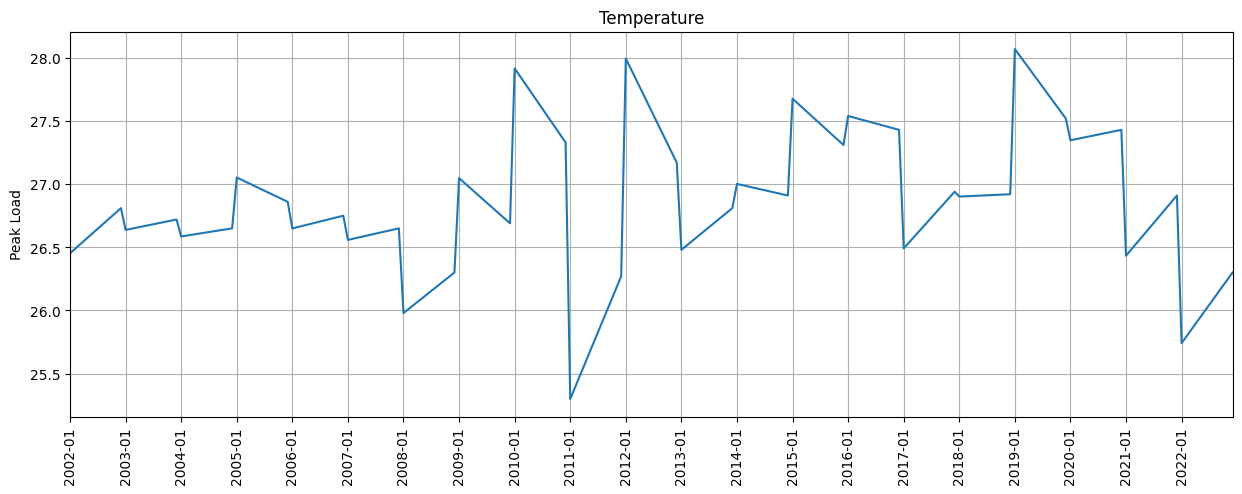

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.title('Temperature')
plt.ylabel('Peak Load')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X)
plt.xticks(X.index[::12], rotation=90)
plt.show()

In [14]:
y = X.Temperature.values.astype(float)

test_size = 24
window_size = 24

train_set = y[:-test_size]
test_set  = y[-test_size:]

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 228
Test:  24


In [15]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

print(f'First item, original: {train_set[0]}')
print(f'First item, scaled: {train_norm[0]}')

First item, original: 26.4525
First item, scaled: [-0.16716777]


In [16]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq, ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [17]:
train_data = input_data(train_norm,window_size)

print(f'Train_data: {len(train_data)}')

Train_data: 204


In [18]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(101)
model = LSTMnetwork().to(device)
model

cuda


LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training 

In [23]:
from tqdm import tqdm
epochs = 5000

for i in tqdm(range(epochs)):
    for seq, y_train in train_data:
        
        seq = seq.to(device)
        y_train = y_train.to(device)
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
                        torch.zeros(1,1,model.hidden_size).to(device))
        
        # apply the model
        y_pred = model(seq)

        # update parameters
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    if (i+1) % 500 == 0:
        # OPTIONAL print statement
        print(f'{i+1} of {epochs} epochs completed')

  4%|▍         | 200/5000 [01:31<41:27,  1.93it/s]

200 of 5000 epochs completed


  8%|▊         | 400/5000 [03:03<39:18,  1.95it/s]

400 of 5000 epochs completed


 12%|█▏        | 600/5000 [04:43<24:40,  2.97it/s]

600 of 5000 epochs completed


 16%|█▌        | 800/5000 [06:08<36:22,  1.92it/s]

800 of 5000 epochs completed


 20%|██        | 1000/5000 [07:47<26:09,  2.55it/s]

1000 of 5000 epochs completed


 24%|██▍       | 1200/5000 [09:16<30:50,  2.05it/s]

1200 of 5000 epochs completed


 28%|██▊       | 1400/5000 [10:51<27:49,  2.16it/s]

1400 of 5000 epochs completed


 32%|███▏      | 1600/5000 [12:31<29:39,  1.91it/s]

1600 of 5000 epochs completed


 36%|███▌      | 1800/5000 [14:11<27:50,  1.92it/s]

1800 of 5000 epochs completed


 40%|████      | 2000/5000 [15:48<21:35,  2.32it/s]

2000 of 5000 epochs completed


 44%|████▍     | 2200/5000 [17:27<24:18,  1.92it/s]

2200 of 5000 epochs completed


 48%|████▊     | 2400/5000 [19:04<22:36,  1.92it/s]

2400 of 5000 epochs completed


 52%|█████▏    | 2600/5000 [20:42<17:13,  2.32it/s]

2600 of 5000 epochs completed


 56%|█████▌    | 2800/5000 [22:13<16:21,  2.24it/s]

2800 of 5000 epochs completed


 60%|██████    | 3000/5000 [23:44<16:22,  2.04it/s]

3000 of 5000 epochs completed


 64%|██████▍   | 3200/5000 [25:22<13:57,  2.15it/s]

3200 of 5000 epochs completed


 68%|██████▊   | 3400/5000 [26:58<13:01,  2.05it/s]

3400 of 5000 epochs completed


 72%|███████▏  | 3600/5000 [28:33<12:07,  1.92it/s]

3600 of 5000 epochs completed


 76%|███████▌  | 3800/5000 [30:11<10:17,  1.94it/s]

3800 of 5000 epochs completed


 80%|████████  | 4000/5000 [31:50<07:53,  2.11it/s]

4000 of 5000 epochs completed


 84%|████████▍ | 4200/5000 [33:23<06:39,  2.00it/s]

4200 of 5000 epochs completed


 88%|████████▊ | 4400/5000 [34:57<03:51,  2.59it/s]

4400 of 5000 epochs completed


 92%|█████████▏| 4600/5000 [36:27<02:17,  2.91it/s]

4600 of 5000 epochs completed


 96%|█████████▌| 4800/5000 [37:55<01:44,  1.91it/s]

4800 of 5000 epochs completed


100%|██████████| 5000/5000 [39:29<00:00,  2.11it/s]

5000 of 5000 epochs completed


## Testing 

In [24]:
future = 24 #months
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future): #future
    seq = torch.FloatTensor(preds[-window_size:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
                        torch.zeros(1,1,model.hidden_size).to(device))
        preds.append(model(seq).item())
        
# preds[window_size:]

In [25]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
# true_predictions = true_predictions.astype(str).tolist()

In [26]:
true_predictions = true_predictions.reshape(-1)

In [27]:
day = np.arange('2021-01', '2023-01', dtype='datetime64[M]') #.astype('datetime64[D]')
day = day.astype(str).tolist()

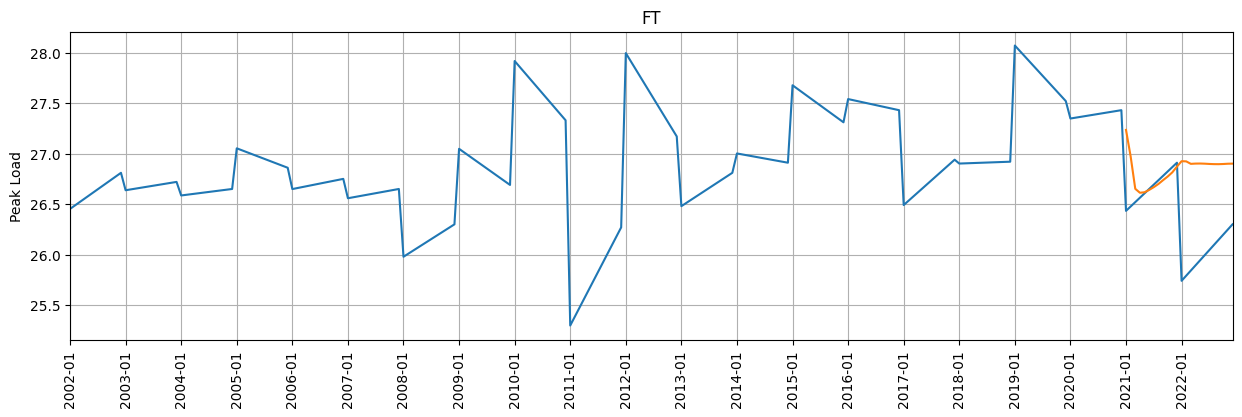

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.title('FT')
plt.ylabel('Peak Load')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X)
plt.plot(day, true_predictions)
plt.xticks(X.index[::12], rotation=90)
plt.show()

KeyError: 'Peak'

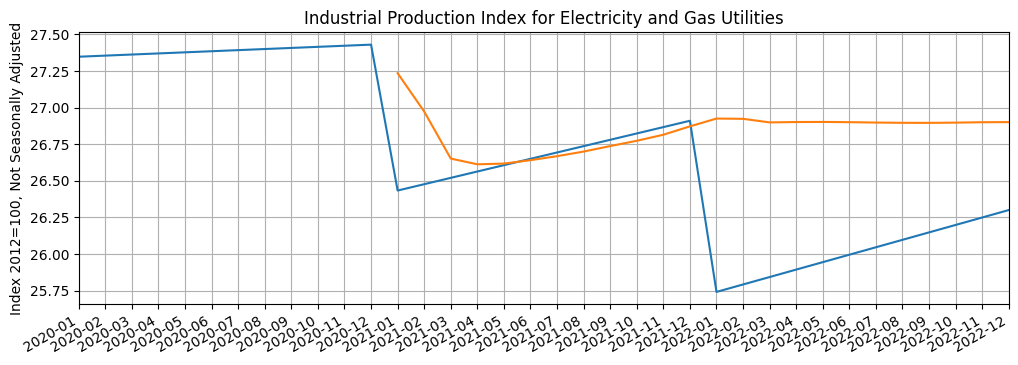

In [30]:
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(X['Temperature']['2020-01':])
plt.plot(day, true_predictions)
plt.xticks(X['Peak']['2020-01':].index[::3], rotation=90)
plt.show()

In [31]:
test_set

array([26.43333333, 26.47666667, 26.52      , 26.56333333, 26.60666667,
       26.65      , 26.69333333, 26.73666667, 26.78      , 26.82333333,
       26.86666667, 26.91      , 25.74083333, 25.79166667, 25.8425    ,
       25.89333333, 25.94416667, 25.995     , 26.04583333, 26.09666667,
       26.1475    , 26.19833333, 26.24916667, 26.3       ])

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

MSE  = mean_squared_error(test_set, true_predictions)
RMSE = math.sqrt(MSE)
MAE  = mean_absolute_error(test_set, true_predictions)

MSE, RMSE, MAE

(0.4445135775826144, 0.6667185145041454, 0.5140575009373936)

In [33]:
T_RMSE = RMSE/(np.max(test_set) + np.min(test_set))
T_RMSE

0.012663019221848763

## Inference 

In [34]:
future = 84 #months
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future): #future
    seq = torch.FloatTensor(preds[-window_size:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
                        torch.zeros(1,1,model.hidden_size).to(device))
        preds.append(model(seq).item())
        
# preds[window_size:]

In [35]:
true_predictions = scaler.inverse_transform(np.array(preds[-future:]).reshape(-1, 1))
# true_predictions = true_predictions.astype(str).tolist()

In [36]:
true_predictions = true_predictions.reshape(-1)
true_predictions.shape

(84,)

In [37]:
day = np.arange('2021-01', '2028-01', dtype='datetime64[M]') #.astype('datetime64[D]')
day = day.astype(str).tolist()
len(day)

84

In [38]:
day[::12]

['2021-01', '2022-01', '2023-01', '2024-01', '2025-01', '2026-01', '2027-01']

In [39]:
total = X.index[::12].values.tolist() + day[::12]

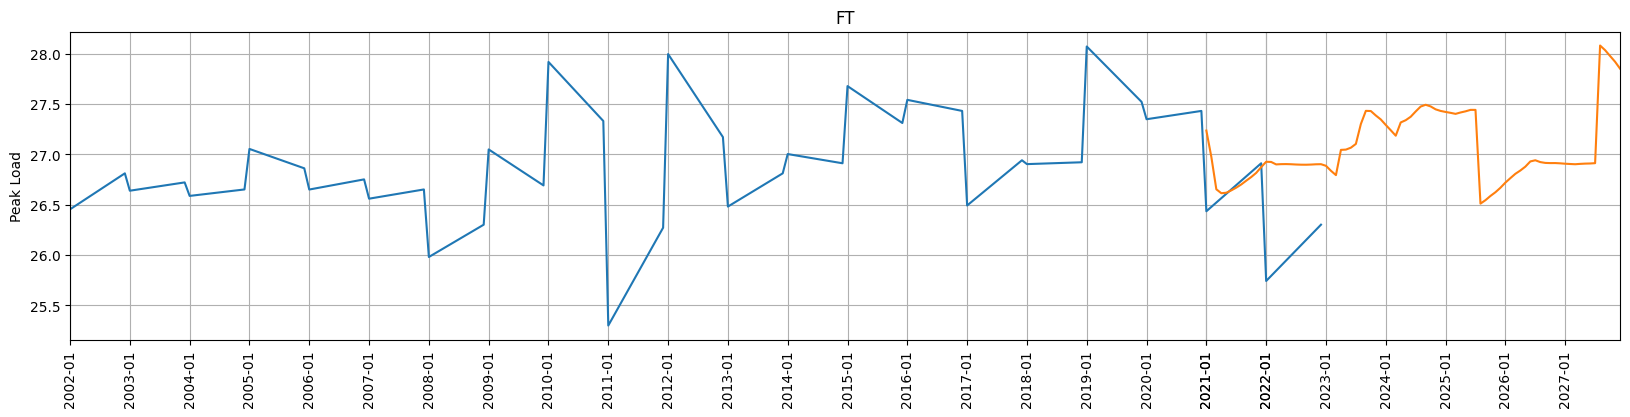

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.title('FT')
plt.ylabel('Peak Load')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X)
plt.plot(day, true_predictions)
plt.xticks(total, rotation=90)
plt.show()

In [41]:
df_peak = pd.DataFrame({"Date":day, "Temperature":true_predictions})
df_peak.set_index("Date",inplace=True)
df_peak

,Temperature
Date,
2021-01,27.234921
2021-02,26.973058
2021-03,26.651684
2021-04,26.612572
2021-05,26.617465
...,...
2027-08,28.079634
2027-09,28.033712
2027-10,27.975995
